# Adaptive Experiment Design - Modules


## Generate samples from sources, mix them, and run the ICA on the observational distribtuion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import seaborn as sns
import pandas as pd
import matplotlib
import networkx as nx
matplotlib.rcParams['figure.dpi'] = 100

# 1. Generate Non-Gaussian Sources
def generate_exogenous_samples(n, D, distributions=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    if distributions is None:
        distributions = ['sine', 'square', 'sawtooth', 'laplace', 'bernoulli',
                         'exponential', 'uniform', 'student_t']

    time = np.linspace(0, 10, D)
    samples = np.zeros((D, n))
    used_distributions = []

    for i in range(n):
        dist = distributions[i % len(distributions)]
        used_distributions.append(dist)
        if dist == 'sine':
            freq = np.random.uniform(0.5, 4)
            phase = np.random.uniform(0, 2 * np.pi)
            samples[:, i] = np.sin(2 * np.pi * freq * time + phase)
        elif dist == 'square':
            freq = np.random.uniform(0.5, 4)
            samples[:, i] = np.sign(np.sin(2 * np.pi * freq * time))
        elif dist == 'sawtooth':
            freq = np.random.uniform(0.5, 4)
            samples[:, i] = 2 * (time * freq % 1) - 1
        elif dist == 'laplace':
            samples[:, i] = np.random.laplace(loc=0.0, scale=1.0, size=D)
        elif dist == 'bernoulli':
            samples[:, i] = np.random.choice([-1, 1], size=D)
        elif dist == 'exponential':
            samples[:, i] = np.random.exponential(scale=1.0, size=D)
        elif dist == 'uniform':
            samples[:, i] = np.random.uniform(low=-1.0, high=1.0, size=D)
        elif dist == 'student_t':
            samples[:, i] = np.random.standard_t(df=3, size=D)
        else:
            samples[:, i] = np.random.standard_normal(size=D)

    return samples, used_distributions


# --- Step 1: Generate the mixing matrix ---
def generate_sparse_mixing_matrix(n, zero_prob=0.6, weight_scale=4.0, min_abs=0.6, seed=None):
    if seed is not None:
        np.random.seed(seed)

    W = np.zeros((n, n))
    nonzero_count = 0

    for i in range(n):
        for j in range(n):
            if i != j and np.random.rand() > zero_prob:
                # Draw until abs(value) >= min_abs
                while True:
                    val = np.random.uniform(-weight_scale, weight_scale)
                    if abs(val) >= min_abs:
                        W[i, j] = val
                        nonzero_count += 1
                        break

    # Guarantee at least one non-zero off-diagonal
    if nonzero_count == 0:
        i, j = np.random.choice(n, 2, replace=False)
        val = np.random.uniform(-weight_scale, weight_scale)
        if abs(val) >= min_abs:
            W[i, j] = val
        elif (np.random.rand() >= 0.5):
            W[i, j] = min_abs
        else:
            W[i, j] = -min_abs


    I_minus_W = np.eye(n) - W
    return I_minus_W



# --- Step 2: Mix the source signals ---
def mix_sources(I_minus_W, sources):
    return sources @ np.linalg.inv(I_minus_W.T)


def build_bipartite_graph(I_minus_W_thresh):
    """
    Create a bipartite graph from the thresholded ICA-recovered matrix.

    Parameters:
    - I_minus_W_thresh: numpy.ndarray, shape (n, n), thresholded matrix

    Returns:
    - G: networkx.Graph, bipartite graph
    - row_nodes: list of str, left node labels ('r0', ..., 'rn-1')
    - col_nodes: list of str, right node labels ('0', ..., 'n-1')
    """
    n = I_minus_W_thresh.shape[0]
    G = nx.Graph()

    # Define row and column nodes
    row_nodes = [f"r{i}" for i in range(n)]
    col_nodes = [f"{j}" for j in range(n)]

    # Add nodes with bipartite attributes
    G.add_nodes_from(row_nodes, bipartite=0)  # Left set
    G.add_nodes_from(col_nodes, bipartite=1)  # Right set

    # Add edges where I_minus_W_thresh[i, j] ≠ 0
    for i in range(n):
        for j in range(n):
            if I_minus_W_thresh[i, j] != 0:
                G.add_edge(f"r{i}", f"{j}")

    return G, row_nodes, col_nodes

def has_perfect_matching(G, row_nodes, col_nodes):
    matching = nx.bipartite.maximum_matching(G, top_nodes=row_nodes)
    return len(matching) // 2 == len(row_nodes)

# --- Step 3: Normalize ICA output rows and threshold ---
def normalize_and_threshold(
    matrix,
    scale=4.0,
    rel_threshold_start=0.5,
    abs_threshold_start=0.3,
    discount_factor=0.9,
    Max_Itr = 100,
    verbose=False
):
    """
    Normalize and threshold the ICA matrix adaptively until the resulting
    bipartite graph admits a perfect matching.

    Returns a matchable thresholded matrix.
    """
    rel_threshold = rel_threshold_start
    abs_threshold = abs_threshold_start


    # Loop to gradually relax the thresholds
    while (Max_Itr > 0):
        # Apply thresholding
        matrix_thr = matrix * (np.abs(matrix) > abs_threshold)
        normalized_matrix = scale * matrix_thr / np.linalg.norm(matrix_thr, ord=np.inf, axis=1, keepdims=True)
        thresholded_matrix = normalized_matrix * (np.abs(normalized_matrix) > rel_threshold)

        # Check if the bipartite graph has a perfect matching
        G, row_nodes, col_nodes = build_bipartite_graph(thresholded_matrix)

        if has_perfect_matching(G, row_nodes, col_nodes):
            if verbose:
                print(f"[INFO] Thresholding succeeded at rel={rel_threshold:.2f}, abs={abs_threshold:.2f}")
            return thresholded_matrix

        # Reduce thresholds for next attempt
        rel_threshold = rel_threshold * discount_factor
        abs_threshold = abs_threshold * discount_factor

        Max_Itr -= 1

    if verbose:
        print("[WARN] Could not find a threshold with perfect matching. Returning final attempt.")

    # Return the last attempted matrix even if it failed
    return thresholded_matrix


def permute_and_scale_rows(matrix, seed=None):
    """
    Return a random row-permuted and row-scaled version of the input matrix.

    Parameters:
    - matrix: np.ndarray, input matrix of shape (n, m)
    - seed: int or None, for reproducibility

    Returns:
    - transformed_matrix: np.ndarray, row-permuted and row-scaled matrix
    - row_permutation: np.ndarray, the applied row permutation indices
    - scaling_factors: np.ndarray, the diagonal entries used for scaling
    """
    if seed is not None:
        np.random.seed(seed)

    n_rows = matrix.shape[0]

    # Random row permutation
    row_permutation = np.random.permutation(n_rows)
    permuted_matrix = matrix[row_permutation, :]

    # Random positive scaling factors
    scaling_factors = np.random.uniform(0.5, 2.0, size=n_rows)  # You can adjust the range
    scaling_matrix = np.diag(scaling_factors)

    # Apply scaling
    transformed_matrix = scaling_matrix @ permuted_matrix

    return transformed_matrix, row_permutation, scaling_factors

### Simulation with ICA

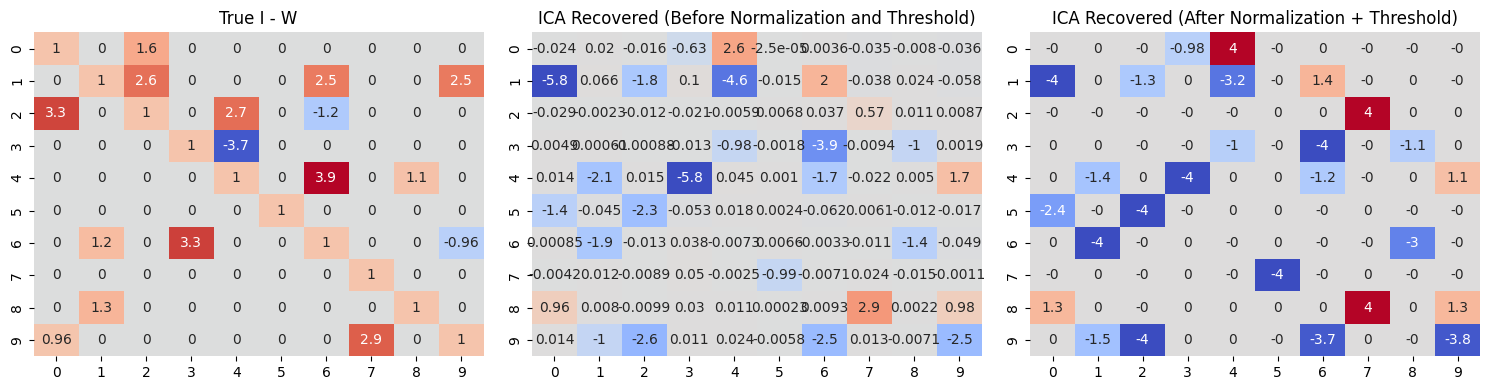

In [6]:
# --- Simulation parameters ---
n_sources = 10
n_samples = 20000
# np.random.seed(12)
sources, used_distributions = generate_exogenous_samples(n=n_sources, D=n_samples, seed=None)

scale = 4
min_val = 0.6
prob = 0.8
I_minus_W_true = generate_sparse_mixing_matrix(n_sources, zero_prob=prob, weight_scale=scale, min_abs=min_val, seed=None)
X_mixed = mix_sources(I_minus_W_true, sources)

ica = FastICA(n_components=n_sources, max_iter=2000, tol=1e-5, random_state=0)
S_est = ica.fit_transform(X_mixed)
I_minus_W_ica = ica.components_

I_minus_W_thresh = normalize_and_threshold(I_minus_W_ica)

# --- Plotting the results ---
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(I_minus_W_true, ax=axes[0], annot=True, cmap="coolwarm", center=0, cbar=False)
axes[0].set_title("True I - W")

sns.heatmap(I_minus_W_ica, ax=axes[1], annot=True, cmap="coolwarm", center=0, cbar=False)
axes[1].set_title("ICA Recovered (Before Normalization and Threshold)")

sns.heatmap(I_minus_W_thresh, ax=axes[2], annot=True, cmap="coolwarm", center=0, cbar=False)
axes[2].set_title("ICA Recovered (After Normalization + Threshold)")

plt.tight_layout()
plt.show()


In [7]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def best_row_permutation(true_matrix, recovered_matrix, match_by='cosine'):
    """
    Permute and align rows of recovered_matrix to match true_matrix using best matching.

    Parameters:
    - true_matrix: ground truth matrix (n x d)
    - recovered_matrix: ICA-recovered matrix (n x d)
    - match_by: 'cosine' or 'l2'

    Returns:
    - aligned_matrix: permuted and sign-corrected version of recovered_matrix
    - permutation: list of matched indices
    """
    n = true_matrix.shape[0]
    cost_matrix = np.zeros((n, n))

    # Normalize rows
    true_normed = true_matrix / np.linalg.norm(true_matrix, axis=1, keepdims=True)
    rec_normed = recovered_matrix / np.linalg.norm(recovered_matrix, axis=1, keepdims=True)

    for i in range(n):
        for j in range(n):
            if match_by == 'cosine':
                sim = np.abs(np.dot(true_normed[i], rec_normed[j]))
                cost_matrix[i, j] = 1 - sim  # want to maximize similarity → minimize cost
            elif match_by == 'l2':
                diff = np.linalg.norm(true_normed[i] - rec_normed[j])
                diff_flipped = np.linalg.norm(true_normed[i] + rec_normed[j])
                cost_matrix[i, j] = min(diff, diff_flipped)
            else:
                raise ValueError("match_by must be 'cosine' or 'l2'")

    # Solve assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Reorder and flip signs if needed
    aligned_matrix = np.zeros_like(recovered_matrix)
    for i, j in zip(row_ind, col_ind):
        rec_row = recovered_matrix[j]
        true_row = true_matrix[i]
        if np.dot(rec_row, true_row) < 0:
            rec_row = -rec_row
        aligned_matrix[i] = rec_row

    return aligned_matrix, col_ind.tolist()


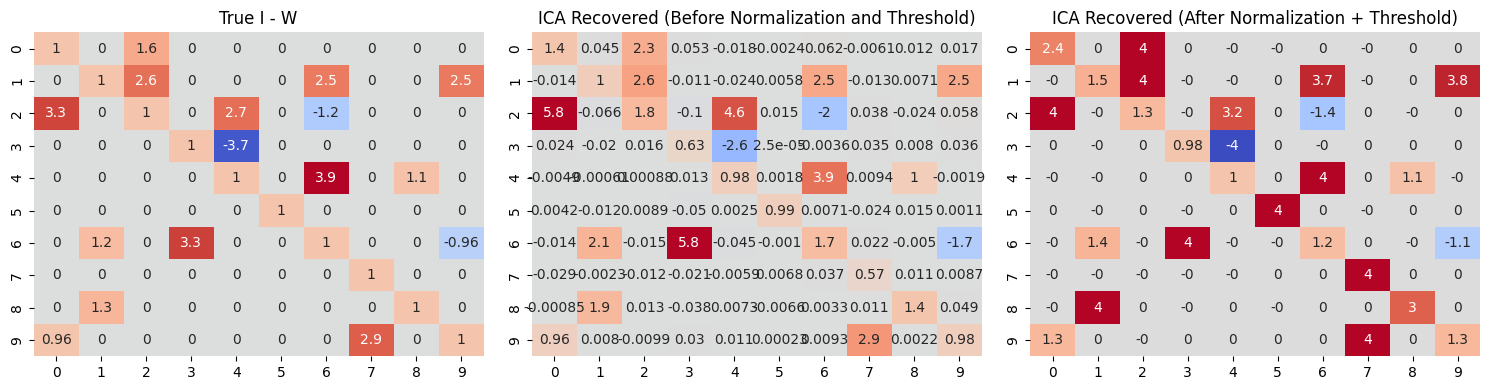

In [8]:
aligned_ica, permutation = best_row_permutation(I_minus_W_true, I_minus_W_ica, match_by='cosine')

# You can now threshold and normalize aligned ICA
I_minus_W_thresh = normalize_and_threshold(aligned_ica, scale=scale)

# --- Plotting the results ---
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(I_minus_W_true, ax=axes[0], annot=True, cmap="coolwarm", center=0, cbar=False)
axes[0].set_title("True I - W")

sns.heatmap(aligned_ica, ax=axes[1], annot=True, cmap="coolwarm", center=0, cbar=False)
axes[1].set_title("ICA Recovered (Before Normalization and Threshold)")

sns.heatmap(I_minus_W_thresh, ax=axes[2], annot=True, cmap="coolwarm", center=0, cbar=False)
axes[2].set_title("ICA Recovered (After Normalization + Threshold)")

plt.tight_layout()
plt.show()

### Simulation without ICA

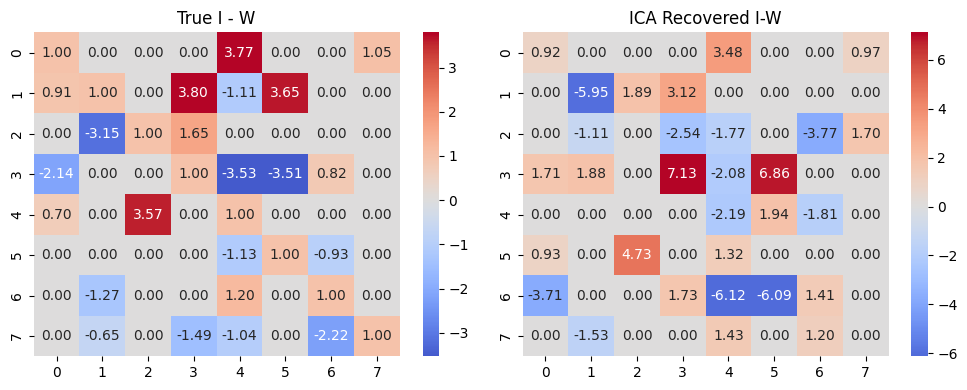

In [5]:
# --- Simulation parameters ---
n_sources = 8

scale = 4
min_val = 0.5
prob = 0.6
I_minus_W_true = generate_sparse_mixing_matrix(n_sources, zero_prob=prob, weight_scale=scale, min_abs=min_val, seed=None)
I_minus_W_thresh,_,_ = permute_and_scale_rows(I_minus_W_true, seed=None)


# --- Plotting the results ---
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(I_minus_W_true, ax=axes[0], annot=True, fmt=".2f", cmap="coolwarm", center=0)
axes[0].set_title("True I - W")

sns.heatmap(I_minus_W_thresh, ax=axes[1], annot=True, fmt=".2f", cmap="coolwarm", center=0)
axes[1].set_title("ICA Recovered I-W")

plt.tight_layout()
plt.show()


## Sample uniformly from the equivalence class of graphs




## Check Unique Matching and Refine

In [9]:
def check_unique_matching_and_refine(G, row_nodes, col_nodes):
    """
    Check if the bipartite graph admits a unique perfect matching using a greedy refinement approach.
    Prunes the original graph G and node lists in-place.

    Parameters:
    - G: networkx.Graph, bipartite graph (will be modified!)
    - row_nodes: list of str, will be pruned
    - col_nodes: list of str, will be pruned

    Returns:
    - is_unique: bool, True if matching is unique
    - matching: dict, the unique matching found so far
    - G: the pruned bipartite graph
    - row_nodes: updated row node list
    - col_nodes: updated column node list
    """
    matching = {}

    while col_nodes:
        # Select column node with minimum degree
        min_deg_col = min(col_nodes, key=lambda c: G.degree[c])

        # Check degree
        deg = G.degree[min_deg_col]

        if deg == 0:
            return False, matching, G, row_nodes, col_nodes  # No matching possible

        if deg > 1:
            return False, matching, G, row_nodes, col_nodes  # Multiple choices: non-unique

        # Unique match
        neighbor = next(iter(G.neighbors(min_deg_col)))
        matching[neighbor] = min_deg_col  # r_i → j

        # Prune matched nodes
        G.remove_node(min_deg_col)
        G.remove_node(neighbor)

        col_nodes.remove(min_deg_col)
        row_nodes.remove(neighbor)

    return True, matching, G, row_nodes, col_nodes



G, row_nodes, col_nodes = build_bipartite_graph(I_minus_W_thresh)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

is_unique, matching, G, row_nodes, col_nodes = check_unique_matching_and_refine(G, row_nodes, col_nodes)

if is_unique:
    if matching is not None:
        print("No cycles found. Unique perfect matching identified:")
        print(matching)
        # break the loop or terminate algorithm
    else:
        print("No cycles and no perfect matching. Something is wrong.")
else:
    print("Cycle detected. Continue with sampling.")

Number of nodes: 20
Number of edges: 26
Cycle detected. Continue with sampling.


In [10]:
import networkx as nx
import numpy as np
import random
import copy

import copy
import random
import networkx as nx

def enumerate_perfect_matchings(G, row_nodes, col_nodes):
    """
    Enumerate all perfect matchings in a bipartite graph G.
    Only returns matchings where every row_node is matched to a unique col_node.

    Returns:
        A list of dicts: each dict maps row_node -> col_node
    """
    def backtrack(matching, remaining_rows, used_cols):
        if not remaining_rows:
            matchings.append(dict(matching))
            return

        r = remaining_rows[0]
        for c in G.neighbors(r):
            if c not in used_cols:
                matching.append((r, c))
                backtrack(matching, remaining_rows[1:], used_cols | {c})
                matching.pop()

    matchings = []
    backtrack([], row_nodes, set())
    return matchings if matchings else False



def greedy_min_degree_sampler(G, row_nodes, col_nodes, M, mode='exact'):
    """
    Return M sampled or all exact perfect matchings from a bipartite graph.

    Parameters:
    - G: bipartite graph (nx.Graph)
    - row_nodes: list of row vertex names
    - col_nodes: list of column vertex names
    - M: number of samples to generate (only relevant if mode == 'sample')
    - mode: 'sample' or 'exact'

    Returns:
    - matchings: list of dicts, each dict maps row_node -> col_node
    """
    matchings = []

    if mode == 'sample':
        for _ in range(M):
            G_copy = copy.deepcopy(G)
            row_set = set(row_nodes)
            col_set = set(col_nodes)
            matching = {}

            while row_set:
                # Select row node with minimum degree
                r = min(row_set, key=lambda x: G_copy.degree[x])
                neighbors = list(G_copy.neighbors(r))
                if not neighbors:
                    break  # matching failure

                # Choose a neighbor uniformly at random
                c = random.choice(neighbors)
                matching[r] = c

                # Remove both r and c from the graph
                G_copy.remove_node(r)
                G_copy.remove_node(c)
                row_set.remove(r)
                col_set.remove(c)

            if len(matching) == len(row_nodes):
                matchings.append(matching)

        if not matchings:
            return False
        return matchings

    elif mode == 'exact':
        return enumerate_perfect_matchings(G, row_nodes, col_nodes)

    else:
        raise ValueError(f"Unknown mode: {mode}")



# Example usage
M = 100
sampled_matchings = greedy_min_degree_sampler(G, row_nodes, col_nodes, M, mode='exact')

## Compute normalized marginal benefit

In [11]:
import numpy as np
from collections import defaultdict

def edge_probs_from_matching(bipartite_graph, matchings):
    # Initialize a dictionary to store the count of appearances for each edge
    edge_counts = defaultdict(int)
    for edge in bipartite_graph.edges():
      edge_counts[edge] = 0

    total_matchings = len(matchings)

    # Count how many times each edge appears in the matchings
    for matching in matchings:
        for r in list(matching.keys()):
            edge_counts[(r, matching[r])] += 1

    # Precompute the probability p_i for each edge (r, c)
    edge_probs = {edge: edge_counts[edge] / total_matchings for edge in edge_counts}

    return edge_probs

def compute_normalized_marginal_benefit(bipartite_graph, edge_probs, col_nodes):
    """
    Estimate the normalized marginal benefit for each column vertex in the bipartite graph.

    Parameters:
    - bipartite_graph: NetworkX bipartite graph
    - col_nodes: List of column vertices

    Returns:
    - normalized_benefits: Dictionary with column vertices as keys and their marginal benefits as values
    """

    edge_probs = edge_probs_from_matching(bipartite_graph, edge_probs)

    # Now calculate the normalized marginal benefit for each column vertex (c)
    normalized_benefits = {}

    # Iterate over each column vertex (node in the bipartite graph)
    for c in col_nodes:
        # Sum the normalized marginal benefit for this column vertex
        sum_benefit = 0
        for r in bipartite_graph.neighbors(c):
            # Calculate p_i (probability of this edge appearing in a matching)
            p_i = edge_probs[(r, c)]
            # Calculate p_i * (1 - p_i) and add it to the sum
            sum_benefit += p_i * (1 - p_i)
        normalized_benefits[c] = sum_benefit

    return normalized_benefits

# Example usage
# Assuming 'G' is the bipartite graph and 'sampled_matchings' is a list of M sampled matchings
# and 'col_nodes' is a list of column nodes (vertices) in the bipartite graph
normalized_benefits = compute_normalized_marginal_benefit(G, sampled_matchings, col_nodes)

# Print the results
for c, benefit in normalized_benefits.items():
    print(f"Column vertex {c} has normalized marginal benefit: {benefit}")

Column vertex 0 has normalized marginal benefit: 0.6426592797783933
Column vertex 1 has normalized marginal benefit: 0.6648199445983379
Column vertex 2 has normalized marginal benefit: 0.5761772853185595
Column vertex 3 has normalized marginal benefit: 0.43213296398891965
Column vertex 4 has normalized marginal benefit: 0.6648199445983379
Column vertex 6 has normalized marginal benefit: 0.7479224376731302
Column vertex 7 has normalized marginal benefit: 0.0
Column vertex 8 has normalized marginal benefit: 0.46537396121883656
Column vertex 9 has normalized marginal benefit: 0.5318559556786704


## Variable selection - Perform the intervention

Intervened index: 6


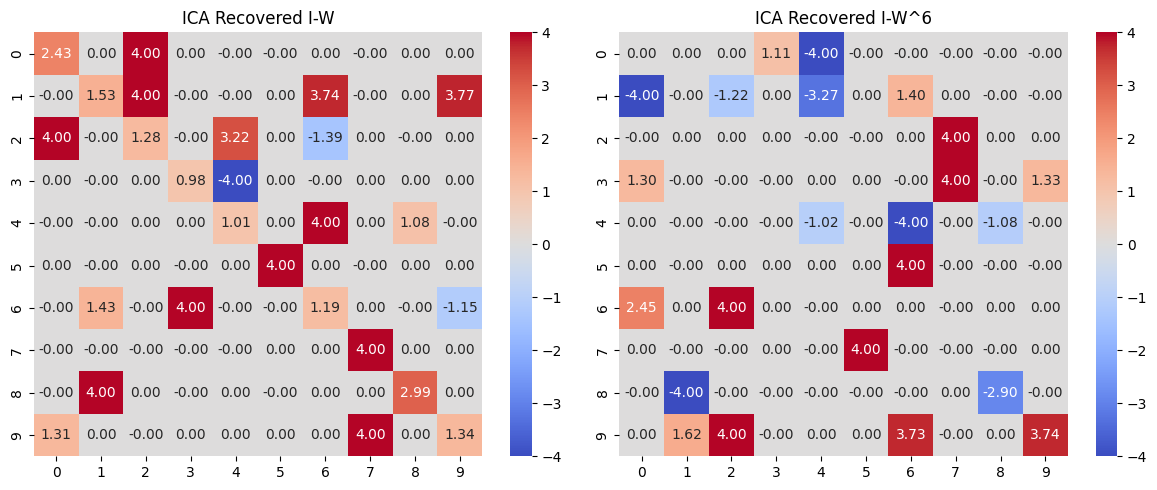

In [12]:
import numpy as np
from sklearn.decomposition import FastICA


def select_variable_to_intervene(normalized_benefits):
    return int(max(normalized_benefits, key=normalized_benefits.get))

def perform_intervention_with_ICA(j, n_sources, n_samples, I_minus_W_true, used_distributions):
    """
    Perform intervention on a selected variable (column vertex) and recover the mixing matrix using ICA.

    Parameters:
    - n_sources: The number of original sources (exogenous noises)
    - n_samples: The number of samples to generate
    - I_minus_W_true: The true mixing matrix (I - W)
    - used_distributions: List of distributions used for each source

    Returns:
    - I_minus_W_j_ica: The ICA-recovered mixing matrix (I - W_ICA) after the intervention
    """

    # Step 2: Perform intervention by modifying the mixing matrix
    # Zero out the j-th row in I - W and replace it with a new independent noise vector (tilde_e_j)
    I_minus_W_j = I_minus_W_true.copy()  # Create a copy of the true mixing matrix
    I_minus_W_j[j, :] = 0  # Zero out the j-th row
    I_minus_W_j[j, j] = 1  # Set the diagonal entry of the j-th row to 1

    # Step 3: Resample sources, except for the j-th source which will be replaced with new independent noise
    new_used_distributions = used_distributions.copy()  # Create a copy of the distributions
    new_used_distributions[j] = 'laplace'  # Replace the j-th source distribution with 'laplace' or another one

    # Generate new sources with the updated distributions
    new_sources, _ = generate_exogenous_samples(n_sources , n_samples, distributions=new_used_distributions, seed=None)

    # Step 4: Apply the modified mixing matrix to the new sources (intervention on the j-th source)
    X_intervention = mix_sources(I_minus_W_j,new_sources)  # Apply inverse to the sources (mixing matrix)

    # Step 5: Run ICA on the interventional data to recover I - W_ICA
    ica = FastICA(n_components=n_sources, max_iter=2000, tol=1e-5, random_state=0)
    sources_recovered = ica.fit_transform(X_intervention)  # Run ICA to recover the sources
    I_minus_W_j_ica = ica.components_  # Get the estimated mixing matrix from ICA

    # Step 6: Normalize the recovered matrix
    I_minus_W_j_ica = normalize_and_threshold(I_minus_W_j_ica)


    return I_minus_W_j_ica

def perform_intervention_without_ICA(j, I_minus_W_true):

    I_minus_W_j = I_minus_W_true.copy()  # Create a copy of the true mixing matrix
    I_minus_W_j[j, :] = 0  # Zero out the j-th row
    I_minus_W_j[j, j] = 1  # Set the diagonal entry of the j-th row to 1
    I_minus_W_j_ica,_,_ = permute_and_scale_rows(I_minus_W_j, seed=None)

    return I_minus_W_j_ica

# Example usage:
# Assuming sources are generated, I_minus_W_true is the true mixing matrix, and bipartite graph is defined
intervened_index = select_variable_to_intervene(normalized_benefits)
print("Intervened index:", intervened_index)
I_minus_W_j_ica = perform_intervention_with_ICA(intervened_index, n_sources, n_samples, I_minus_W_true, used_distributions)

# Print or inspect the recovered matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(I_minus_W_thresh, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("ICA Recovered I-W")

plt.subplot(1, 2, 2)
sns.heatmap(I_minus_W_j_ica, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(f"ICA Recovered I-W^{intervened_index}")

plt.tight_layout()
plt.show()


## Find the true matching edge

In [13]:
import numpy as np

def rank_candidate_rows_for_intervened_column(I_minus_W_thresh, I_minus_W_j_ica, j):
    """
    Rank rows in I_minus_W_thresh that are most likely to match the true row for intervened column j,
    by comparing with rows of I_minus_W_j_ica, excluding the intervened one.

    Returns:
        List of candidate row indices in I_minus_W_thresh, sorted from most likely (least similar to others) to least likely.
    """
    # Step 1: Normalize both matrices row-wise
    I_norm = I_minus_W_thresh / np.linalg.norm(I_minus_W_thresh, axis=1, keepdims=True)
    J_norm = I_minus_W_j_ica / np.linalg.norm(I_minus_W_j_ica, axis=1, keepdims=True)

    n_rows = J_norm.shape[0]

    # Step 2: Find the row index in J corresponding to the intervened variable j
    j_row_idx = int(np.argmax(np.abs(J_norm @ np.eye(1, n_rows, j).T)))

    # Step 3: For each row in I, compute its *total* similarity to all J rows except j_row_idx
    row_scores = []
    for i in range(I_norm.shape[0]):
        # Only consider if the row has non-zero in column j (must have influence on j)
        if np.abs(I_minus_W_thresh[i, j]) < 1e-6:
            continue

        total_similarity = 0
        for k in range(J_norm.shape[0]):
            if k == j_row_idx:
                continue
            sim = np.abs(np.dot(I_norm[i], J_norm[k]))
            total_similarity += sim

        row_scores.append((i, total_similarity))

    # Step 4: Sort by total similarity ascending (less similar → more likely to be the true row)
    sorted_candidates = sorted(row_scores, key=lambda x: x[1])
    ranked_edges = [(i,j) for i, _ in sorted_candidates]

    return ranked_edges


# Example usage:
ranked_edges = rank_candidate_rows_for_intervened_column(I_minus_W_thresh, I_minus_W_j_ica, intervened_index)
print("True matching edge:", ranked_edges)

True matching edge: [(6, 6), (4, 6), (1, 6), (2, 6)]


## Prune the bipartite graph

In [14]:
import networkx as nx

def remove_edge(bipartite_graph, row_nodes, col_nodes, edge):
    """
    Remove the true edge (r_i, j) and the corresponding row/column from the bipartite graph.

    Parameters:
    - bipartite_graph: The current bipartite graph (NetworkX Graph object).
    - true_edge: The true edge (r_i, j) to be removed (with r_i as a string).

    Returns:
    - reduced_bipartite_graph: The reduced bipartite graph after removing the true edge and corresponding rows/columns.
    """
    r_i, j = edge  # True edge where r_i is the row (string) and j is the column (string)

    # Remove the row (r_i) and the column (j) nodes (this will automatically remove their edges)
    bipartite_graph.remove_node('r'+str(r_i))  # Remove the row node
    bipartite_graph.remove_node(str(j))    # Remove the column node

    row_nodes.remove('r'+str(r_i))  # Remove the row node from the list of row nodes
    col_nodes.remove(str(j))  # Remove the column node from the list of column nodes

    return bipartite_graph, row_nodes, col_nodes


# Example usage:
# Assuming 'bipartite_graph' is the current graph and 'true_edge' is found using the previous function
# 'true_edge' is a tuple like (0, 2)
reduced_G, reduced_row_nodes, reduced_col_nodes = remove_edge(G, row_nodes, col_nodes, ranked_edges[0])

# Now, we can continue running the algorithm on the reduced bipartite graph.
print("nodes:", reduced_G.nodes())
print("edges:", reduced_G.edges())

nodes: ['r0', 'r1', 'r2', 'r3', 'r4', 'r7', 'r8', 'r9', '0', '1', '2', '3', '4', '7', '8', '9']
edges: [('r0', '0'), ('r0', '2'), ('r1', '1'), ('r1', '2'), ('r1', '9'), ('r2', '0'), ('r2', '2'), ('r2', '4'), ('r3', '3'), ('r3', '4'), ('r4', '4'), ('r4', '8'), ('r7', '7'), ('r8', '1'), ('r8', '8'), ('r9', '0'), ('r9', '7'), ('r9', '9')]


# Adaptive Experiment Design

## With ICA Implementation

In [15]:
def perform_adaptive_experiments_with_ICA(K, M_samples, I_minus_W_true, observational_matrix, n_sources, n_samples, used_distributions, strategy_type='marginalized benefit', mode='exact'):
    success = True
    bipartite_graph, row_nodes, col_nodes = build_bipartite_graph(observational_matrix)
    experiment_count = 0
    perfect_matching = {}

    for t in range(K):
        is_unique, partial_matching, bipartite_graph, row_nodes, col_nodes = check_unique_matching_and_refine(
            bipartite_graph, row_nodes, col_nodes
        )
        perfect_matching.update(partial_matching)

        if is_unique:
            break

        # --- Select variable to intervene ---
        if strategy_type == 'marginalized benefit':
            sampled_matchings = greedy_min_degree_sampler(bipartite_graph, row_nodes, col_nodes, M_samples, mode=mode)
            if sampled_matchings == False:
                print('No matching!')
                success = False
                break
            normalized_benefits = compute_normalized_marginal_benefit(bipartite_graph, sampled_matchings, col_nodes)
            intervened_index = select_variable_to_intervene(normalized_benefits)

        elif strategy_type == 'random':
            intervened_index = int(np.random.choice([int(c) for c in col_nodes]))

        elif strategy_type == 'maxdegree':
            degrees = {int(c): bipartite_graph.degree[c] for c in col_nodes}
            intervened_index = max(degrees, key=degrees.get)

        else:
            raise ValueError(f"Unknown strategy_type: {strategy_type}")

        # --- Perform intervention ---
        I_minus_W_j_ica = perform_intervention_with_ICA(intervened_index, n_sources, n_samples, I_minus_W_true, used_distributions)
        experiment_count += 1

        # --- Rank possible matching edges for the intervened variable ---
        ranked_edges = rank_candidate_rows_for_intervened_column(observational_matrix, I_minus_W_j_ica, intervened_index)

        # --- Try removing candidate edges until one leads to a graph with at least one perfect matching ---
        accepted = False
        for (r_i, j) in ranked_edges:
            r_node, c_node = f"r{r_i}", f"{j}"

            if r_node not in bipartite_graph.nodes() or c_node not in bipartite_graph.nodes():
                continue  # Skip if nodes are not present

            # Copy the graph and attempt to remove this edge
            temp_graph = bipartite_graph.copy()
            temp_rows = row_nodes.copy()
            temp_cols = col_nodes.copy()

            temp_graph, temp_rows, temp_cols = remove_edge(temp_graph, temp_rows, temp_cols, (r_i, j))

            # Check if at least one perfect matching exists
            try:
                matching = nx.algorithms.bipartite.maximum_matching(temp_graph, top_nodes=temp_rows)
                if len(matching) // 2 == len(temp_rows):  # Perfect matching
                    # Accept this edge and update the real graph
                    bipartite_graph, row_nodes, col_nodes = remove_edge(bipartite_graph, row_nodes, col_nodes, (r_i, j))
                    perfect_matching[r_node] = c_node
                    accepted = True
                    break
            except:
                continue  # If error or no matching, skip

        if not accepted:
            print(f"No valid matching edge found for intervention on variable {intervened_index}")
            success = False
            break

    return bipartite_graph, experiment_count, perfect_matching, success


def evaluate_final_estimate(I_minus_W_thresh, I_minus_W_true, perfect_matching):
    """
    Reconstructs the estimated causal matrix from ICA output and compares it to the true one.

    Parameters:
    - I_minus_W_thresh: np.ndarray, the thresholded ICA output (rows unpermuted)
    - I_minus_W_true: np.ndarray, the ground truth I - W matrix
    - perfect_matching: dict, maps 'r{i}' to '{j}' indicating row-to-column assignments

    Returns:
    - relative_error: float, Frobenius norm of error / norm of true matrix
    - estimated_W: np.ndarray, final estimated causal matrix
    - true_W: np.ndarray, true causal matrix
    """

    n = I_minus_W_thresh.shape[0]
    A_est = np.zeros_like(I_minus_W_thresh)

    for r_node, c_node in perfect_matching.items():
        i = int(r_node[1:])  # extract row index
        j = int(c_node)      # extract column index
        A_est[j] = I_minus_W_thresh[i]

    # Normalize rows to make diagonal = 1
    diag_entries = A_est[np.arange(n), np.arange(n)]
    A_est_normalized = A_est / diag_entries[:, np.newaxis]

    # Compute estimated W and true W
    estimated_W = np.eye(n) - A_est_normalized
    true_W = np.eye(n) - I_minus_W_true

    # Compute relative Frobenius norm error
    error = np.linalg.norm(estimated_W - true_W, ord='fro')
    true_norm = np.linalg.norm(true_W, ord='fro')
    relative_error = error / true_norm

    return relative_error, estimated_W, true_W


def adaptive_experiment_design_with_ICA(K, n_sources, n_samples, zero_probability=0.5, M_samples=1000, mode='exact'):
    """
    ICA-based adaptive experiment design for Cyclic LSCMs using three strategies.

    Parameters:
    - K: int, number of interventions (budget)
    - n_sources: int, number of sources (variables)
    - n_samples: int, number of samples per experiment
    - zero_probability: float, probability of zero entries in I - W
    - M_samples: int, number of samples for the matching sampler
    - mode: 'exact' or 'sample'

    Returns:
    - experiment_count_adaptive: int, interventions used by adaptive strategy
    - experiment_count_random: int, interventions used by random strategy
    - experiment_count_maxdeg: int, interventions used by max-degree strategy
    - fvs_size: int, feedback vertex set size (ground truth difficulty)
    - success: bool, True if all runs succeeded
    """
    success = True

    # Step 1: Create true model and generate observational data
    sources, used_distributions = generate_exogenous_samples(n=n_sources, D=n_samples, seed=None)
    I_minus_W_true = generate_sparse_mixing_matrix(n_sources, zero_prob=zero_probability, weight_scale=4.0, seed=None)
    X_mixed = mix_sources(I_minus_W_true, sources)

    # Step 2: Run ICA on observational data
    ica = FastICA(n_components=n_sources, max_iter=2000, tol=1e-5, random_state=0)
    S_est = ica.fit_transform(X_mixed)
    I_minus_W_ica = ica.components_
    I_minus_W_thresh = normalize_and_threshold(I_minus_W_ica)

    # Step 3: Evaluate the graph's complexity
    true_graph = generate_true_graph_from_I_minus_W(I_minus_W_true)
    fvs_size = len(minimum_feedback_vertex_set(true_graph))

    # Step 4: Run three strategies
    _, experiment_count_marginalized_benefit, perfect_matching_marginalized_benefit, success_marginalized_benefit = perform_adaptive_experiments_with_ICA(
        K, M_samples, I_minus_W_true, I_minus_W_thresh, n_sources, n_samples, used_distributions,
        strategy_type='marginalized benefit', mode=mode
    )

    _, experiment_count_random, _, success_random = perform_adaptive_experiments_with_ICA(
        K, M_samples, I_minus_W_true, I_minus_W_thresh, n_sources, n_samples, used_distributions,
        strategy_type='random', mode=mode
    )

    _, experiment_count_maxdeg, _, success_maxdeg = perform_adaptive_experiments_with_ICA(
        K, M_samples, I_minus_W_true, I_minus_W_thresh, n_sources, n_samples, used_distributions,
        strategy_type='maxdegree', mode=mode
    )

    if not success_marginalized_benefit or not success_random or not success_maxdeg:
        success = False

    relative_error_mb, _, _ = evaluate_final_estimate(I_minus_W_thresh, I_minus_W_true, perfect_matching_marginalized_benefit)

    return experiment_count_marginalized_benefit, experiment_count_random, experiment_count_maxdeg, fvs_size, success, relative_error_mb



## Without ICA implementation

In [ ]:
from inspect import modulesbyfile
import numpy as np
import networkx as nx
import random

def perform_adaptive_experiments_without_ICA(K, M_samples, I_minus_W_true, I_minus_W_ica, strategy_type='marginalized benefit', mode='exact'):
    success = True
    bipartite_graph, row_nodes, col_nodes = build_bipartite_graph(I_minus_W_ica)
    experiment_count = 0
    perfect_matching = {}  # NEW: To store the complete true matching

    for t in range(K):
        # Step 1: Refine and accumulate passive matchings
        is_unique, partial_matching, bipartite_graph, row_nodes, col_nodes = check_unique_matching_and_refine(
            bipartite_graph, row_nodes, col_nodes
        )
        perfect_matching.update(partial_matching)  # accumulate known edges

        if is_unique:
            break

        # Step 2: Choose intervention index
        if strategy_type == 'marginalized benefit':
            sampled_matchings = greedy_min_degree_sampler(bipartite_graph, row_nodes, col_nodes, M_samples, mode=mode)
            if sampled_matchings == False:
                print('No matching!')
                success = False
                break
            normalized_benefits = compute_normalized_marginal_benefit(bipartite_graph, sampled_matchings, col_nodes)
            intervened_index = select_variable_to_intervene(normalized_benefits)

        elif strategy_type == 'random':
            intervened_index = int(np.random.choice([int(c) for c in col_nodes]))

        elif strategy_type == 'maxdegree':
            degrees = {int(c): bipartite_graph.degree[c] for c in col_nodes}
            intervened_index = max(degrees, key=degrees.get)

        else:
            raise ValueError(f"Unknown strategy_type: {strategy_type}")

        # Step 3: Perform intervention
        I_minus_W_j_ica = perform_intervention_without_ICA(intervened_index, I_minus_W_true)
        experiment_count += 1

       # --- Rank possible matching edges for the intervened variable ---
        ranked_edges = rank_candidate_rows_for_intervened_column(I_minus_W_ica, I_minus_W_j_ica, intervened_index)

        # --- Try removing candidate edges until one leads to a graph with at least one perfect matching ---
        accepted = False
        for (r_i, j) in ranked_edges:
            r_node, c_node = f"r{r_i}", f"{j}"

            if r_node not in bipartite_graph.nodes() or c_node not in bipartite_graph.nodes():
                continue  # Skip if nodes are not present

            # Copy the graph and attempt to remove this edge
            temp_graph = bipartite_graph.copy()
            temp_rows = row_nodes.copy()
            temp_cols = col_nodes.copy()

            temp_graph, temp_rows, temp_cols = remove_edge(temp_graph, temp_rows, temp_cols, (r_i, j))

            # Check if at least one perfect matching exists
            try:
                matching = nx.algorithms.bipartite.maximum_matching(temp_graph, top_nodes=temp_rows)
                if len(matching) // 2 == len(temp_rows):  # Perfect matching
                    # Accept this edge and update the real graph
                    bipartite_graph, row_nodes, col_nodes = remove_edge(bipartite_graph, row_nodes, col_nodes, (r_i, j))
                    perfect_matching[r_node] = c_node
                    accepted = True
                    break
            except:
                continue  # If error or no matching, skip

        if not accepted:
            print(f"No valid matching edge found for intervention on variable {intervened_index}")
            success = False
            break

    return bipartite_graph, experiment_count, perfect_matching, success



def adaptive_experiment_design_without_ICA(K, n_sources, zero_probability=0.5, M_samples=1000, mode='exact'):
    """
    Adaptive experiment design for Cyclic LSCMs using a greedy strategy.

    Parameters:
    - K: int, number of interventions (budget)
    - n_sources: int, number of sources (variables)
    - zero_probability: float, the probability of zero entries in the mixing matrix
    - M_samples: int, the number of samples of the sampler oracle
    """

    success = True

    # Step 1: Run ICA on the observational data to recover I - W_ICA
    I_minus_W_true = generate_sparse_mixing_matrix(n_sources, zero_prob=zero_probability, weight_scale=4.0, min_abs=0.5, seed=None)
    I_minus_W_ica,_,_ = permute_and_scale_rows(I_minus_W_true, seed=None)

    true_graph = generate_true_graph_from_I_minus_W(I_minus_W_true)
    fvs_size = len(minimum_feedback_vertex_set(true_graph))

    _, experiment_count_adaptive_submodular, _, success_adaptive_submodular = perform_adaptive_experiments_without_ICA(K, M_samples, I_minus_W_true, I_minus_W_ica, strategy_type='marginalized benefit', mode = mode)
    _, experiment_count_random, _, success_random = perform_adaptive_experiments_without_ICA(K, M_samples, I_minus_W_true, I_minus_W_ica, strategy_type='random', mode = mode)
    _, experiment_count_max_degree, _, success_max_degree = perform_adaptive_experiments_without_ICA(K, M_samples, I_minus_W_true, I_minus_W_ica, strategy_type='maxdegree', mode = mode)

    if not success_adaptive_submodular or not success_random or not success_max_degree:
        success = False

    return experiment_count_adaptive_submodular, experiment_count_random, experiment_count_max_degree, fvs_size, success

## Test


In [16]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.9 MB/s eta 0:00:00


In [17]:
import networkx as nx
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary

def generate_true_graph_from_I_minus_W(I_minus_W):
    """
    Convert I - W matrix to directed graph.
    The edges go from column j to row i if (I - W)[i, j] ≠ 0 and i ≠ j.
    """
    n = I_minus_W.shape[0]
    G = nx.DiGraph()
    G.add_nodes_from(range(n))

    W = np.eye(n) - I_minus_W  # Recover W from I - W

    for i in range(n):
        for j in range(n):
            if i != j and W[i, j] != 0:
                G.add_edge(j, i)  # W[i, j] means edge from j → i

    return G

def minimum_feedback_vertex_set(G):
    """
    Compute the minimum feedback vertex set using integer programming.
    """
    prob = LpProblem("MinimumFeedbackVertexSet", LpMinimize)
    node_vars = LpVariable.dicts("Node", G.nodes(), 0, 1, LpBinary)

    # Objective: minimize number of nodes in FVS
    prob += lpSum(node_vars[n] for n in G.nodes()), "MinimizeFVS"

    # Add constraints for each cycle
    for cycle in nx.simple_cycles(G):
        prob += lpSum(node_vars[n] for n in cycle) >= 1

    prob.solve()
    fvs = [n for n in G.nodes() if node_vars[n].varValue == 1]
    return fvs

In [20]:
# Example usage:
n_sources = 10  # Number of sources
n_samples = 20000  # Number of samples
K = 10  # Number of interventions (budget)
zero_prob = 0.85
M = 1000
emb, er, em, fvs, success, relative_error_mb = adaptive_experiment_design_with_ICA(K, n_sources, n_samples, zero_probability=zero_prob, M_samples=M, mode='exact')

if success:
    print(f"Our strategy needed {emb} experiments.")
    print(f"Random strategy needed {er} experiments.")
    print(f"Max-degree strategy needed {em} experiments.")
    print(f"FVS size: {fvs}")
else:
    print("The experiment was not successful!")

Our strategy needed 2 experiments.
Random strategy needed 4 experiments.
Max-degree strategy needed 3 experiments.
FVS size: 2


## Size of the Feedback Vertex Set (FVS)

## Experiments

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Parameters
n_sources_range = range(4, 21)
n_samples = 20000
repeats_per_setting = 100
zero_probability = 0.8
M = 1000
c = 1
sampler_mode = 'exact'
number_of_failure = 0

# Storage
avg_adaptive = []
avg_random = []
avg_maxdeg = []
avg_fvs = []
relative_error = []

std_adaptive = []
std_random = []
std_maxdeg = []
std_fvs = []

adaptive_lower_bound = []
adaptive_upper_bound = []

# Run experiments
for n_sources in n_sources_range:
    print(f"Running experiments for {n_sources} sources...")
    K = int(c * n_sources) # experiment budjet
    adapt_list, rand_list, maxdeg_list, fvs_list, relative_error_list = [], [], [], [], []

    for _ in range(repeats_per_setting):
        edge_prob = round(random.uniform(round(1/n_sources, 3), round(1/n_sources, 3) + 0.015), 3)
        emb, er, em, fvs, success, relative_error_mb = adaptive_experiment_design_with_ICA(
            K, n_sources, n_samples,  max(1 - edge_prob, zero_probability), M_samples=M, mode=sampler_mode
        )
        if success:
            adapt_list.append(emb)
            rand_list.append(er)
            maxdeg_list.append(em)
            fvs_list.append(fvs)
            relative_error_list.append(relative_error_mb)
        else:
            number_of_failure += 1

    # Compute averages and standard deviations
    adapt_avg = np.mean(adapt_list)
    rand_avg = np.mean(rand_list)
    maxdeg_avg = np.mean(maxdeg_list)
    fvs_avg = np.mean(fvs_list)

    adapt_std = np.std(adapt_list)
    rand_std = np.std(rand_list)
    maxdeg_std = np.std(maxdeg_list)
    fvs_std = np.std(fvs_list)

    # Save averages
    avg_adaptive.append(adapt_avg)
    avg_random.append(rand_avg)
    avg_maxdeg.append(maxdeg_avg)
    avg_fvs.append(fvs_avg)

    # Save stds
    std_adaptive.append(adapt_std)
    std_random.append(rand_std)
    std_maxdeg.append(maxdeg_std)
    std_fvs.append(fvs_std)

    # Save error
    relative_error.append(relative_error_list)

    # For shaded region under adaptive curve
    alpha = 1 - 0.2
    adaptive_lower_bound.append(adapt_avg * alpha)
    adaptive_upper_bound.append(adapt_avg)

Running experiments for 4 sources...
Running experiments for 5 sources...
Running experiments for 6 sources...
Running experiments for 7 sources...
Running experiments for 8 sources...
Running experiments for 9 sources...
Running experiments for 10 sources...
Running experiments for 11 sources...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Running experiments for 12 sources...
Running experiments for 13 sources...
Running experiments for 14 sources...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Running experiments for 15 sources...
Running experiments for 16 sources...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Running experiments for 17 sources...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Running experiments for 18 sources...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Running experiments for 19 sources...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the ma

Running experiments for 20 sources...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the ma

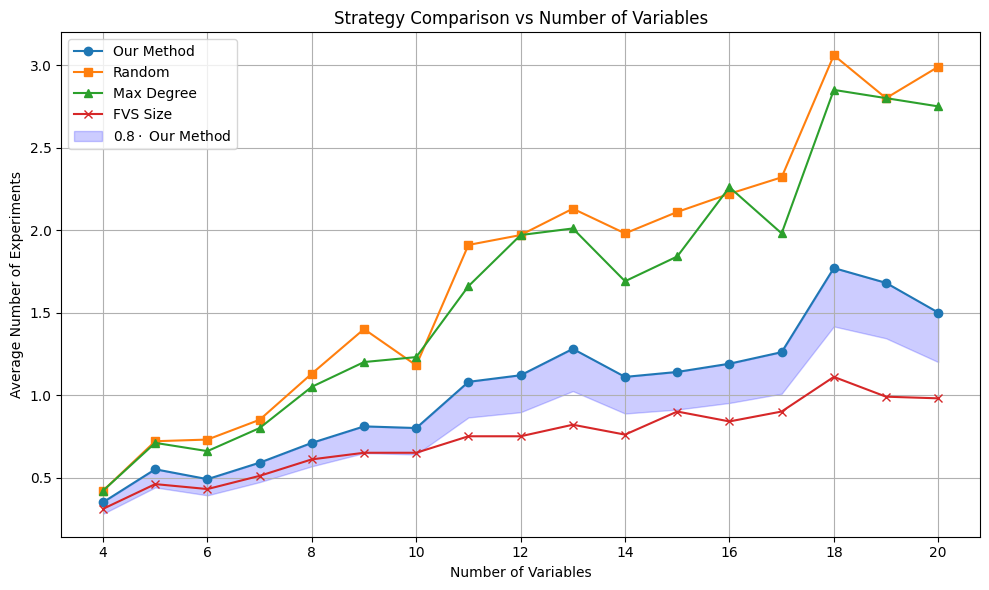

In [22]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(n_sources_range, avg_adaptive, label="Our Method", marker='o')
plt.plot(n_sources_range, avg_random, label="Random", marker='s')
plt.plot(n_sources_range, avg_maxdeg, label="Max Degree", marker='^')
plt.plot(n_sources_range, avg_fvs, label="FVS Size", marker='x')

# Shade adaptive range
plt.fill_between(
    n_sources_range,
    adaptive_lower_bound,
    adaptive_upper_bound,
    color='blue',
    alpha=0.2,
    label=r"$0.8 \cdot$ Our Method"
)

plt.xlabel("Number of Variables")
plt.ylabel("Average Number of Experiments")
plt.title("Strategy Comparison vs Number of Variables")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

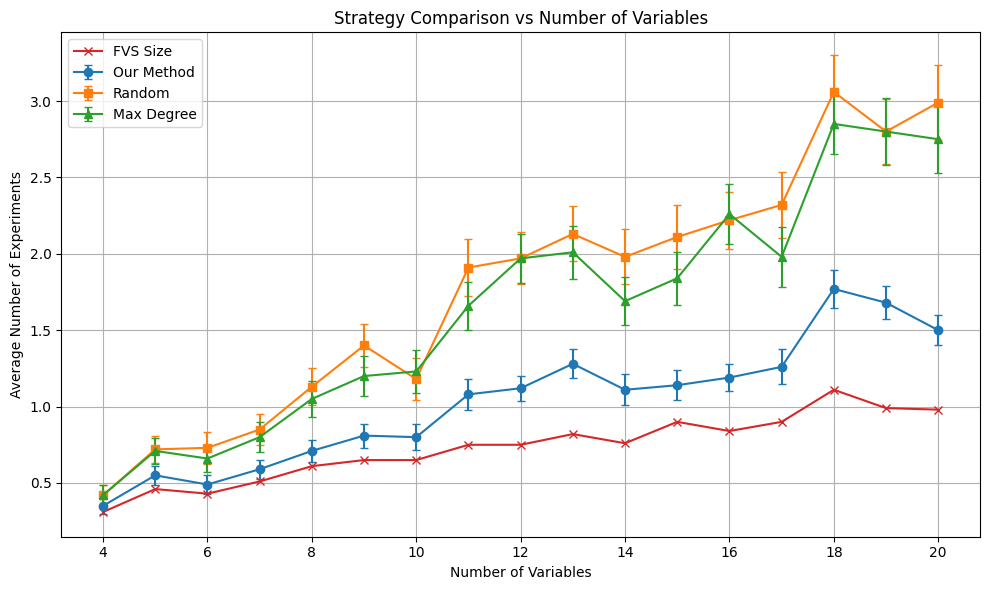

In [24]:
plt.figure(figsize=(10, 6))


alpha = np.sqrt(1/repeats_per_setting)

# Plot with error bars
plt.errorbar(
    n_sources_range, avg_adaptive, yerr=(alpha)*np.array(std_adaptive),
    label="Our Method", marker='o', capsize=3, linestyle='-', color='C0'
)
plt.errorbar(
    n_sources_range, avg_random, yerr=(alpha)*np.array(std_random),
    label="Random", marker='s', capsize=3, linestyle='-', color='C1'
)
plt.errorbar(
    n_sources_range, avg_maxdeg, yerr=(alpha)*np.array(std_maxdeg),
    label="Max Degree", marker='^', capsize=3, linestyle='-', color='C2'
)

# Plot FVS line without error bars
plt.plot(
    n_sources_range, avg_fvs,
    label="FVS Size", marker='x', linestyle='-', color='C3'
)

# Shade under adaptive curve
# plt.fill_between(
#     n_sources_range,
#     adaptive_lower_bound,
#     adaptive_upper_bound,
#     color='C0',
#     alpha=0.2,
#     label=r"$0.8 \cdot$ Our Method"
# )

plt.xlabel("Number of Variables")
plt.ylabel("Average Number of Experiments")
plt.title("Strategy Comparison vs Number of Variables")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


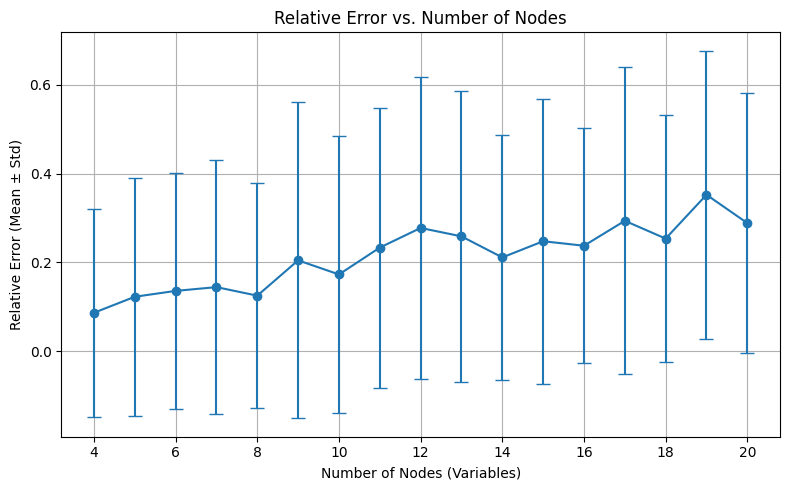

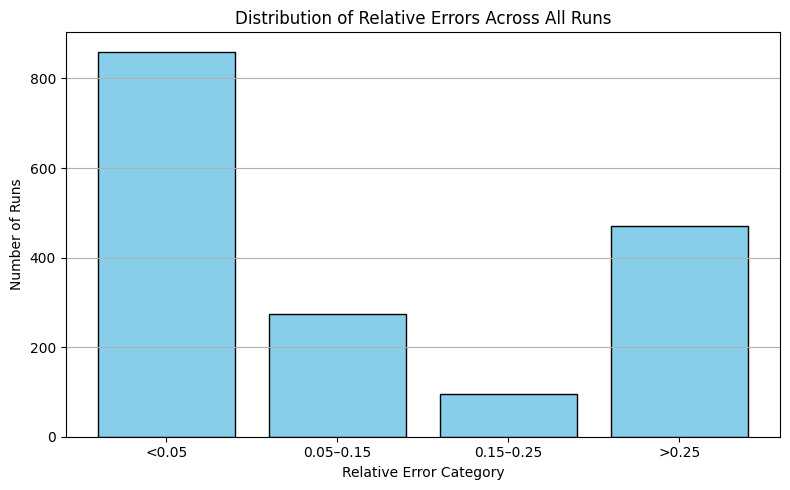

In [25]:
# Plot 1: Mean and Std Dev vs. number of sources
means = [np.mean(errors) for errors in relative_error]
stds = [np.std(errors) for errors in relative_error]

plt.figure(figsize=(8, 5))
plt.errorbar(n_sources_range, means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel("Number of Nodes (Variables)")
plt.ylabel("Relative Error (Mean ± Std)")
plt.title("Relative Error vs. Number of Nodes")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Histogram of relative error categories across all experiments
bins = [0, 0.05, 0.15, 0.25, 1.0]
labels = ["<0.05", "0.05–0.15", "0.15–0.25", ">0.25"]
category_counts = [0] * 4

for sublist in relative_error:
    for err in sublist:
        if err < 0.05:
            category_counts[0] += 1
        elif err < 0.15:
            category_counts[1] += 1
        elif err < 0.25:
            category_counts[2] += 1
        else:
            category_counts[3] += 1

plt.figure(figsize=(8, 5))
plt.bar(labels, category_counts, color='skyblue', edgecolor='black')
plt.xlabel("Relative Error Category")
plt.ylabel("Number of Runs")
plt.title("Distribution of Relative Errors Across All Runs")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [26]:
category_counts

[860, 275, 95, 470]

In [27]:
470/(860+275+95+470)

0.27647058823529413

Save Results to CSV

In [ ]:
import pandas as pd

# Create a DataFrame from all lists
results_df = pd.DataFrame({
    'n_sources': list(n_sources_range),
    'avg_adaptive': avg_adaptive,
    'std_adaptive': std_adaptive,
    'avg_random': avg_random,
    'std_random': std_random,
    'avg_maxdeg': avg_maxdeg,
    'std_maxdeg': std_maxdeg,
    'avg_fvs': avg_fvs,
    'std_fvs': std_fvs,
    'adaptive_lower_bound': adaptive_lower_bound,
    'adaptive_upper_bound': adaptive_upper_bound,
})

# Save to CSV
results_df.to_csv("adaptive_experiment_results.csv", index=False)


Read the CSV Later

In [ ]:
df = pd.read_csv("adaptive_experiment_results.csv")

# Access example:
avg_adaptive = df['avg_adaptive'].tolist()
std_random = df['std_random'].tolist()
